# Figures for Presentation in AMS Annual Meeting in Denver 2023 

## X-Band Precipitation Estimates for the Surface Atmosphere Integrated Field Laboratory (SAIL) Field Experiment
### Presenting Author: Joe O'Brien 

In [1]:
import os
import glob
import time
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import fiona
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from math import atan2 as atan2
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib import ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

import pyart
import act
import wradlib as wrl


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
%matplotlib inline

In [3]:
fiona.drvsupport.supported_drivers['lib?kml'] = 'rw' # enable KML support which is disabled by default
fiona.drvsupport.supported_drivers['LIBKML'] = 'rw' # enable KML support which is disabled by default

## Read in the East River Domain file

In [4]:
east_river = gpd.read_file('../../data/site-locations/East_River.kml')

In [5]:
min_lat = 38.5
max_lat = 39.3
min_lon = -107.45
max_lon = -106.45
####min_lat = 38.71
####max_lat = 39.07
####min_lon = -107.17
####max_lon = -106.71
# zoomed in
zoom_min_lat = 38.85
zoom_max_lat = 39.05
zoom_min_lon = -107.1
zoom_max_lon = -106.80

In [6]:
# Define the splash locations [lon,lat]
kettle_ponds = [-106.9731488, 38.9415427]
brush_creek = [-106.920259, 38.8596282]
avery_point = [-106.9965928, 38.9705885]
pumphouse_site = [-106.9502476, 38.9226741]
M1 = [-106.987, 38.9267]
snodgrass = [-106.978929, 38.926572]

sites = ["AMF2 M1", "Kettle Ponds", "Brush Creek", "Avery Point", 
         "Pumphouse Site", "Snodgrass"]

# Zip these together!
lons, lats = list(zip(M1,
                      kettle_ponds,
                      brush_creek,
                      avery_point,
                      pumphouse_site,
                      snodgrass))

## Read the TIF file

In [7]:
# file obtained from Zach Sherman (zssherman)
tif_file = "/Users/jrobrien/Downloads/sail.tif"

## Define Helper Functions

In [8]:
def _generate_title(radar, ds, field, sweep):
    """ Generates a title for each plot. """
    time_str = ds['time'].data[0]
    fixed_angle = radar.fixed_angle['data'][sweep]
    line_one = "%.1f Deg. %s " % (fixed_angle, time_str)
    field_name = str(field)
    field_name = field_name.replace('_', ' ')
    field_name = field_name[0].upper() + field_name[1:]
    return line_one + '\n' + field_name

def gc_latlon_bear_dist(lat1, lon1, bear, dist):
    """
    Input lat1/lon1 as decimal degrees, as well as bearing and distance from
    the coordinate. Returns lat2/lon2 of final destination. Cannot be
    vectorized due to atan2.
    """
    re = 6371.1  # km
    lat1r = np.deg2rad(lat1)
    lon1r = np.deg2rad(lon1)
    bearr = np.deg2rad(bear)
    lat2r = np.arcsin((np.sin(lat1r) * np.cos(dist/re)) +
                      (np.cos(lat1r) * np.sin(dist/re) * np.cos(bearr)))
    lon2r = lon1r + atan2(np.sin(bearr) * np.sin(dist/re) *
                          np.cos(lat1r), np.cos(dist/re) - np.sin(lat1r) *
                          np.sin(lat2r))
    return np.rad2deg(lat2r), np.rad2deg(lon2r)
 
    
def add_scale_line(scale, ax, projection, color='k',
                  linewidth=None, fontsize=None, fontweight=None):
    """
    Adds a line that shows the map scale in km. The line will automatically
    scale based on zoom level of the map. Works with cartopy.
 
    Parameters
    ----------
    scale : scalar
        Length of line to draw, in km.
    ax : matplotlib.pyplot.Axes instance
        Axes instance to draw line on. It is assumed that this was created
        with a map projection.
    projection : cartopy.crs projection
        Cartopy projection being used in the plot.
 
    Other Parameters
    ----------------
    color : str
        Color of line and text to draw. Default is black.
    """
    frac_lat = 0.1  # distance fraction from bottom of plot
    frac_lon = 0.5  # distance fraction from left of plot
    e1 = ax.get_extent()
    center_lon = e1[0] + frac_lon * (e1[1] - e1[0])
    center_lat = e1[2] + frac_lat * (e1[3] - e1[2])
    # Main line
    lat1, lon1 = gc_latlon_bear_dist(
        center_lat, center_lon, -90, scale / 2.0)  # left point
    lat2, lon2 = gc_latlon_bear_dist(
        center_lat, center_lon, 90, scale / 2.0)  # right point
    if lon1 <= e1[0] or lon2 >= e1[1]:
        warnings.warn('Scale line longer than extent of plot! ' +
                      'Try shortening for best effect.')
    ax.plot([lon1, lon2], [lat1, lat2], linestyle='-',
            color=color, transform=projection, 
            linewidth=linewidth)
    # Draw a vertical hash on the left edge
    lat1a, lon1a = gc_latlon_bear_dist(
        lat1, lon1, 180, frac_lon * scale / 20.0)  # bottom left hash
    lat1b, lon1b = gc_latlon_bear_dist(
        lat1, lon1, 0, frac_lon * scale / 20.0)  # top left hash
    ax.plot([lon1a, lon1b], [lat1a, lat1b], linestyle='-',
            color=color, transform=projection, linewidth=linewidth)
    # Draw a vertical hash on the right edge
    lat2a, lon2a = gc_latlon_bear_dist(
        lat2, lon2, 180, frac_lon * scale / 20.0)  # bottom right hash
    lat2b, lon2b = gc_latlon_bear_dist(
        lat2, lon2, 0, frac_lon * scale / 20.0)  # top right hash
    ax.plot([lon2a, lon2b], [lat2a, lat2b], linestyle='-',
            color=color, transform=projection, linewidth=linewidth)
    # Draw scale label
    ax.text(center_lon, center_lat - frac_lat * (e1[3] - e1[2]) / 3.0,
            str(int(scale)) + ' km', horizontalalignment='center',
            verticalalignment='center', color=color, fontweight=fontweight,
            fontsize=fontsize)

In [9]:
def plot_eastriver(axs, ncolor, scale_color='black', zoom=False):
    # Plot the East River Watershed domain
    east_river.plot(ax=axs, linewidth=2, edgecolor=ncolor, facecolor='None', linestyle=':',)

    axs.plot(0,
             0,
             color=ncolor,
             linestyle=':',
             label='East River Watershed')

    plt.legend(loc='upper right',
               fontsize=12)

    if zoom is True:
        plt.xlim(zoom_min_lon, zoom_max_lon)
        plt.ylim(zoom_min_lat, zoom_max_lat)
    else:
        plt.xlim(min_lon, max_lon)
        plt.ylim(min_lat, max_lat)

    # Add our scale bar
    add_scale_line(10.0, axs, projection=ccrs.PlateCarree(), 
                   color=scale_color, linewidth=3,
                   fontsize=14,
                   fontweight='bold')

    # Add gridlines
    gl = axs.gridlines(crs=ccrs.PlateCarree(),
                       draw_labels=True,
                       linewidth=1, 
                       color='gray', 
                       alpha=0.3,
                       linestyle='--')

    plt.gca().xaxis.set_major_locator(plt.NullLocator())

    # Make sure labels are only plotted on the left and bottom
    gl.top_labels = False
    gl.right_labels = False

    gl.xlabel_style = {'size': 12}
    gl.ylabel_style = {'size': 12}


In [10]:
def beam_block(radar, tif_file, radar_height_offset=10.0,
               beam_width=1.0):
    """
    Beam Block Radar Calculation.
    Parameters
    ----------
    radar : Radar
        Radar object used.
    tif_name : string
        Name of geotiff file to use for the
        calculation.
    radar_height_offset : float
        Add height to the radar altitude for radar towers.
    Other Parameters
    ----------------
    beam_width : float
        Radar's beam width for calculation.
        Default value is 1.0.
    Returns
    -------
    pbb_all : array
        Array of partial beam block fractions for each
        gate in all sweeps.
    cbb_all : array
        Array of cumulative beam block fractions for
        each gate in all sweeps.
    References
    ----------
    Bech, J., B. Codina, J. Lorente, and D. Bebbington,
    2003: The sensitivity of single polarization weather
    radar beam blockage correction to variability in the
    vertical refractivity gradient. J. Atmos. Oceanic
    Technol., 20, 845–855
    Heistermann, M., Jacobi, S., and Pfaff, T., 2013:
    Technical Note: An open source library for processing
    weather radar data (wradlib), Hydrol. Earth Syst.
    Sci., 17, 863-871, doi:10.5194/hess-17-863-2013
    Helmus, J.J. & Collis, S.M., (2016). The Python ARM
    Radar Toolkit (Py-ART), a Library for Working with
    Weather Radar Data in the Python Programming Language.
    Journal of Open Research Software. 4(1), p.e25.
    DOI: http://doi.org/10.5334/jors.119
    """
    # Opening the tif file and getting the values ready to be
    # converted into polar values.
    rasterfile = tif_file
    data_raster = wrl.io.open_raster(rasterfile)
    rastervalues, rastercoords, proj = wrl.georef.extract_raster_dataset(
        data_raster, nodata=None)
    #rastervalues_, rastercoords_, proj = wrl.georef.extract_raster_dataset(data_raster, nodata=-32768.)
    sitecoords = (np.float(radar.longitude['data']),
                  np.float(radar.latitude['data']),
                  np.float(radar.altitude['data'] + radar_height_offset))
    pbb_arrays = []
    cbb_arrays = []
    _range = radar.range['data']
    beamradius = wrl.util.half_power_radius(_range, beam_width)
    # Cycling through all sweeps in the radar object.
    print('Calculating beam blockage.')
    del data_raster
    for i in range(len(radar.sweep_start_ray_index['data'])):
        index_start = radar.sweep_start_ray_index['data'][i]
        index_end = radar.sweep_end_ray_index['data'][i] + 1
        elevs = radar.elevation['data'][index_start:index_end]
        azimuths = radar.azimuth['data'][index_start:index_end]
        rg, azg = np.meshgrid(_range, azimuths)
        rg, eleg = np.meshgrid(_range, elevs)
        nrays = azimuths.shape[0]              # number of rays
        nbins = radar.ngates                   # number of range bins
        bw = beam_width                        # half power beam width (deg)
        range_res = 60.                       # range resolution (meters)
        el = radar.fixed_angle['data'][i]
        coord = wrl.georef.sweep_centroids(nrays, range_res, nbins, el)
        coords = wrl.georef.spherical_to_proj(rg, azg, eleg,
                                              sitecoords, proj=proj)
        lon = coords[..., 0]
        lat = coords[..., 1]
        alt = coords[..., 2]
        polcoords = coords[..., :2]
        rlimits = (lon.min(), lat.min(), lon.max(), lat.max())

        #Clip the region inside our bounding box
        ind = wrl.util.find_bbox_indices(rastercoords, rlimits)
        rastercoords = rastercoords[ind[0]:ind[3], ind[0]:ind[2], ...]
        rastervalues = rastervalues[ind[0]:ind[3], ind[0]:ind[2]]
        polarvalues = wrl.ipol.cart_to_irregular_spline(
            rastercoords, rastervalues, polcoords, order=3,
            prefilter=False)
        # Calculate partial beam blockage using wradlib.
        pbb = wrl.qual.beam_block_frac(polarvalues, alt, beamradius)
        pbb = np.ma.masked_invalid(pbb)
        pbb[pbb < 0] = 0.0
        pbb[pbb > 1] = 1.0
        pbb_arrays.append(pbb)
        # Calculate cumulative beam blockage using wradlib.
        cbb = wrl.qual.cum_beam_block_frac(pbb)
        cbb_arrays.append(cbb)
    pbb_all = np.ma.concatenate(pbb_arrays)
    cbb_all = np.ma.concatenate(cbb_arrays)
    return pbb_all, cbb_all

In [11]:
def sail_mosaic(nradar, column, accum):
    """
    CMAC processed XPrecipRadar file and corresponding RadCLss Column for a given date.

    Moasic is nested list containing one main plot, with 4 side plots
    
    Parameters
    ----------
    radar : str
        Path to radar file wished to be displayed in 'Main' subplot
    column : RadClss column, Xarray Datset
        RadCLss product for a given date.
        
    Returns
    -------
    fig : matplotlib figure
        Matplotlib Mosaic figure
    """
    # Read in the radar file
    radar = pyart.io.read(nradar)
    
    # Extract the 3rd sweep for PPI plot; blocked by mountains
    radar0 = radar.extract_sweeps([2])
    
    # Create the display object from radar file
    display = pyart.graph.RadarMapDisplay(radar0)
    
    # define max/min time from the extracted column
    time_max = column.time.data[-1]
    time_min = column.time.data[0]
    
    # define the radar time
    #radar_time = pd.to_datetime(radar.time['units'].split(' ')[-1][:-1])
    radar_time = pd.to_datetime(radar.time['data'][0], unit='s', origin='unix')
    print(radar_time)

    # Define the lat/lon from sweep 0 for projection plotting
    lats, lons, alt = radar0.get_gate_lat_lon_alt(0)

    # Define reflecitivty data from sweep 0 to display 
    reflectivity = radar0.fields['corrected_reflectivity']['data']

    # Define Site Location
    site_lat = 38.9267
    site_lon = -106.987

    ##date_form = DateFormatter("%H%M UTC %b %d %Y")
       
    #---------------------------------------------------
    # Define the GridSpec for Detailed Subplot Placement
    #---------------------------------------------------
    fig = plt.figure(figsize=(16, 8))

    gs0 = gridspec.GridSpec(1, 2, figure=fig)
    gs00 = gs0[1].subgridspec(4, 1, hspace=0.775)

    # update the extent of the subplot
    gs0.update(top=.90, bottom=0.1, left=0.1, right=.95)

    #-------------------
    # Plot the SAIL PPI
    #-------------------
    ax1 = fig.add_subplot(gs0[0], projection=ccrs.PlateCarree())

    # Create the Radar Display Object
    display = pyart.graph.RadarMapDisplay(radar)

    # Plot the velocity texture

    display.plot_ppi_map('corrected_reflectivity', 
                         ax=ax1,
                         sweep=3, 
                         vmin=-20,
                         vmax=45,
                         lat_lines=None,
                         lon_lines=None,
                         min_lat=zoom_min_lat,
                         max_lat=zoom_max_lat,
                         min_lon=zoom_min_lon,
                         max_lon=zoom_max_lon,
                         ticklabs='',
                         embellish=False,
                         norm=None,
                         cmap="Spectral_r")
    
    # Plot the East River Domain
    plot_eastriver(ax1, 'black', zoom=True)

    # Add site of interest
    ax1.plot(-106.987, 38.9267,
             color='black', linewidth=2, marker='o',
             transform=ccrs.PlateCarree(),
             label="SAIL M1 Site"
             )
    # add a legend
    ax1.legend(loc='upper right')

    #--------------------------------------------
    # Side Plot A - Column Extract - Reflectivity
    #--------------------------------------------
    print(column.time.data[0])
    print(radar_time)
    ax2 = fig.add_subplot(gs00[0])
    label2 = "Horizontal \n Reflectivity \n Factor" + r"($Z_h$)" + "\n" + "[dBZ]"
    reflect = column.sel(site='M1').sel(time=slice(column.time.data[0],
                                                   radar_time)).corrected_reflectivity.plot(x='time',
                                                                                            ax=ax2, 
                                                                                            cmap='Spectral_r',
                                                                                            add_colorbar=True,
                                                                                            vmin=-20,
                                                                                            vmax=45,
                                                                                            cbar_kwargs={'label': label2})

    ax2.set_xlabel(' ')
    ax2.set_ylabel('Height of \n Radar Beam \n [m]')
    ax2.set_title("Extracted Reflectivty Column Above M1 Site")
    ax2.set_xlim(time_min, time_max)
    ax2.set_ylim([3500, 4000])

    #----------------------------------------
    # Side Plot B - Laser Disdromter - PSD
    #----------------------------------------
    ax3 = fig.add_subplot(gs00[1])
    norm = colors.LogNorm(vmin=1, vmax=1000)
    """
    label3 = "Doppler Velocities" + "\n" + r"($Z_h$)" + "\n" + "[dBZ]"
    column.sel(site='M1').sel(time=slice(column.time.data[0],
                                         radar_time)).corrected_velocity.plot(x='time', 
                                                                              ax=ax3, 
                                                                              add_colorbar=True,
                                                                              vmin=-10,
                                                                              vmax=10,
                                                                              cbar_kwargs={'label': "This is the new label2"})
    ax3.set_ylabel('Height of \n Radar Beam \n [m]')
    ax3.set_xlabel(' ')
    ax3.set_title("Extracted Doppler Velocity Above M1 Site")
    ax3.set_xlim(time_min, time_max)
    ax3.set_ylim([3000, 6500])
    """

    psd = column.sel(site="M1").sel(time=slice(column.time.data[0],
                                               radar_time)).number_density_drops.plot(x='time', 
                                                                                      norm=norm, 
                                                                                      cmap='pyart_HomeyerRainbow',
                                                                                      add_colorbar=False,
                                                                                      ax=ax3)
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes("right", size="3%", pad=1.05)
    cax.set_visible(False)
    #cbax = divider.append_axes("right", size="3%")
    cbax = fig.add_axes([0.89, 0.55, 0.007, 0.115])
    cbar2 = fig.colorbar(psd, orientation="vertical", cax=cbax)
    cbar2.set_label('Number Density \n Per Unit Volume \n [#/m3 /mm]')
    #ax4.sharex(axd['SideA'])
    ax3.set_title("Laser Disdrometer Number Density at M1 Site")
    ax3.set_ylabel("Particle Class \n Size Average \n [mm]")
    ax3.set_xlabel(" ")
    ax3.set_xlim(time_min, time_max)
    ax3.set_ylim(0, 10)
    
    #------------------------------------------------------
    # Side Plot C - Laser Disdrometer - Precipitation Rate
    #------------------------------------------------------
    ax5 = fig.add_subplot(gs00[2])
    column.sel(site="M1").sel(time=slice(column.time.data[0],
                                         radar_time)).precip_rate.plot(x='time', 
                                                                       ax=ax5,
                                                                       label='Laser Disdrometer')
    #column.sel(site='M1').sel(time=slice(column.time.data[0],
    #                                     radar_time)).accum_rtnrt.plot(x='time',
    #                                                                   ax=ax5,
    #                                                                   label='Pluvio Weighing Bucket')
    #column.sel(site="M1").isel(height=4).sel(time=slice(column.time.data[0],
    #                                         radar_time)).snow_rate_m2009_1.plot(x='time', 
    #                                                                             ax=ax5,
    #                                                                             label='Braham 1990 #1')
                                                                       

    ax5.set_title("Precipitation Rate at M1 Site")
    ax5.set_xlabel(" ")
    ax5.set_ylabel("Precipitation \n Rate \n [mm/hr]")
    divider = make_axes_locatable(ax5)
    cax = divider.append_axes("right", size="3%", pad=1.05)
    cax.set_visible(False)
    #ax5.xaxis.set_major_formatter(date_form)
    ax5.set_xlim(time_min, time_max)
    ax5.set_ylim([0, 40])
    ax5.legend()
                                                                       
    #-------------------------------------------------------------
    # Side Plot D - Laser Disdrometer - Precipitation Accumulation
    #-------------------------------------------------------------
    ax6 = fig.add_subplot(gs00[3])
    accum['ld'].sel(time=slice(accum['ld'].time.data[0],
                               radar_time)).plot(x='time', 
                                                 ax=ax6, 
                                                 label='Laser Disdrometer')
    #accum['radar'].snow_rate_m2009_1_accumulated.sel(time=slice(accum['radar'].time.data[0],
    #                                                 radar_time)).plot(x='time',
    #                                                                   ax=ax6,
    #                                                                   label='Braham 1990 #1',
    #                                                                   add_legend=True)
    #accum['pluvio'].sel(time=slice(accum['pluvio'].time.data[0],
    #                               radar_time)).plot(x='time', 
    #                                                 ax=ax6,
    #                                                 label='Pluvio Weighing Bucket')
    
    divider = make_axes_locatable(ax6)
    cax = divider.append_axes("right", size="3%", pad=1.05)
    cax.set_visible(False)
    ax6.set_xlim(time_min, time_max)
    ax6.set_title("Precipitation Accumulation at M1 Site")
    ax6.set_xlabel("Time [MM-DD HHZ]")
    ax6.set_ylabel("Preciptiation \n Accumulation \n [mm]")
    ax6.set_ylim([0, 15])
    ax6.legend()

    return fig

### A) RadCLss Location Figure

In [12]:
# grab a cmac file to overlay on-top of
#radar = pyart.io.read('/gpfs/wolf/atm124/proj-shared/gucxprecipradarcmacS2.c1/ppi/202203/gucxprecipradarcmacS2.c1.20220314.024759.nc')
radar = pyart.io.read('/Users/jrobrien/ARM/data/CSU-XPrecipRadar/cmac2/gucxprecipradarcmacM1.c1.20220314-024759.nc')

In [13]:
pd.to_datetime(radar.time['data'][0], unit='s', origin='unix')

Timestamp('2022-03-14 02:47:59')

In [14]:
# Grab a RadCLss file
rad_ds = xr.open_dataset('/Users/jrobrien/ARM/data/CSU-XPrecipRadar/radclss/202203/xprecipradarradclss.c2.20220314.000000.nc')

In [15]:
rad_ds

<xarray.Dataset>
Dimensions:                                   (time: 200, height: 70, site: 8,
                                               particle_size: 32,
                                               raw_fall_velocity: 32)
Coordinates:
  * time                                      (time) datetime64[ns] 2022-03-1...
  * height                                    (height) float64 3.149e+03 ... ...
  * site                                      (site) object 'M1' ... 'snodgrass'
  * particle_size                             (particle_size) float32 0.062 ....
  * raw_fall_velocity                         (raw_fall_velocity) float32 0.0...
Data variables: (12/121)
    DBZ                                       (time, height, site) float64 ...
    VEL                                       (time, height, site) float64 ...
    WIDTH                                     (time, height, site) float64 ...
    ZDR                                       (time, height, site) float64 ...
    PHIDP                                     (time, height, site) float64 ...
    RHOHV                                     (time, height, site) float64 ...
    ...                                        ...
    v_wind                                    (time, site) float64 ...
    wstat                                     (time, site) float64 ...
    asc                                       (time, site) float64 ...
    lat                                       (time, site) float64 ...
    lon                                       (time, site) float64 ...
    alt                                       (time, site) float64 ...
Attributes: (12/24)
    command_line:          
    Conventions:           ARM-1.3 CF/Radial instrument_parameters
    process_version:       
    dod_version:           
    input_datastreams:     
    site_id:               
    ...                    ...
    developers:            Joseph O'Brien, ANL. Maxwell Grover, ANL. Robert J...
    translator:            https://www.arm.gov/capabilities/instruments/xprec...
    mentors:               https://www.arm.gov/connect-with-arm/organization/...
    source:                Colorado State University's X-Band Precipitation R...
    field_names:           DBZ, VEL, WIDTH, ZDR, PHIDP, RHOHV, NCP, DBZhv, cb...
    history:

In [16]:
rad_2 = rad_ds.resample(time='1Min', closed='right').asfreq()

In [17]:
rad_3 = rad_ds.resample(time='1Min', closed='right').interpolate(kind='nearest')

In [18]:
ld_precip_accum = act.utils.accumulate_precip(rad_2.sel(site='M1'), 'precip_rate').precip_rate_accumulated.compute()
gauge_precip_accum = act.utils.accumulate_precip(rad_2.sel(site='M1'), 'intensity_rtnrt').intensity_rtnrt_accumulated.compute()
radar_accum = act.utils.accumulate_precip(rad_3.sel(site='M1').isel(height=4), 'snow_rate_m2009_1').compute()

/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/act/utils/data_utils.py:503: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  t_delta = stats.mode(diff).mode


In [19]:
#radar_acum_2 = radar_accum.snow_rate_m2009_1_accumulated.data / 12

In [20]:
ld_match = ld_precip_accum.resample(time='5Min', 
                                    closed='right').mean(keep_attrs=True).interp(time=rad_ds.time, 
                                                                                 method='linear')

In [21]:
pluvio_match = gauge_precip_accum.resample(time='5Min', 
                                           closed='right').mean(keep_attrs=True).interp(time=rad_ds.time, 
                                                                                        method='linear')

In [22]:
radar_match = radar_accum.resample(time='5Min', 
                                     closed='right').mean(keep_attrs=True).interp(time=rad_ds.time, 
                                                                                        method='linear')

In [23]:
radar_match.snow_rate_m2009_1_accumulated.data = radar_match.snow_rate_m2009_1_accumulated.data / 12

In [24]:
radar_match.snow_rate_m2009_1_accumulated.data

array([ 0.40697911,  1.06220431,  1.51292893,  1.79461198,  2.66778039,
        2.94187751,  2.955074  ,  2.98744847,  3.15122508,  3.32732488,
        3.56077544,  3.73876389,  3.92197947,  3.98049989,  4.05325937,
        4.21902449,  4.43994711,  4.60099495,  5.20418481,  5.58683728,
        7.43256612,  8.66149725, 10.2375014 , 10.41550911, 10.50759485,
       10.67789583, 10.87724745, 10.90917128, 10.90917128, 10.90917128,
       10.91000732, 10.92304749, 10.96764024, 11.01897162, 11.06219223,
       11.1905364 , 11.27086843, 11.34664819, 11.4268429 , 11.50147147,
       12.19248697, 12.36516007, 12.41060029, 12.55579626, 12.67770549,
       12.8058983 , 12.90851263, 13.18471763, 13.7764369 , 14.35364442,
       14.56993899, 14.60318945, 14.65764413, 14.68817833, 14.69236944,
       14.70758582, 15.05338432, 15.31250452, 15.44001724, 15.50067836,
       15.55241458, 15.57648174, 15.5774242 , 15.68439622, 15.96215925,
       16.33057254, 16.45221783, 16.46706227, 16.46706227, 16.46

In [25]:
accum = {'ld' : ld_match, 'pluvio' : pluvio_match, 'radar' : radar_match}

/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


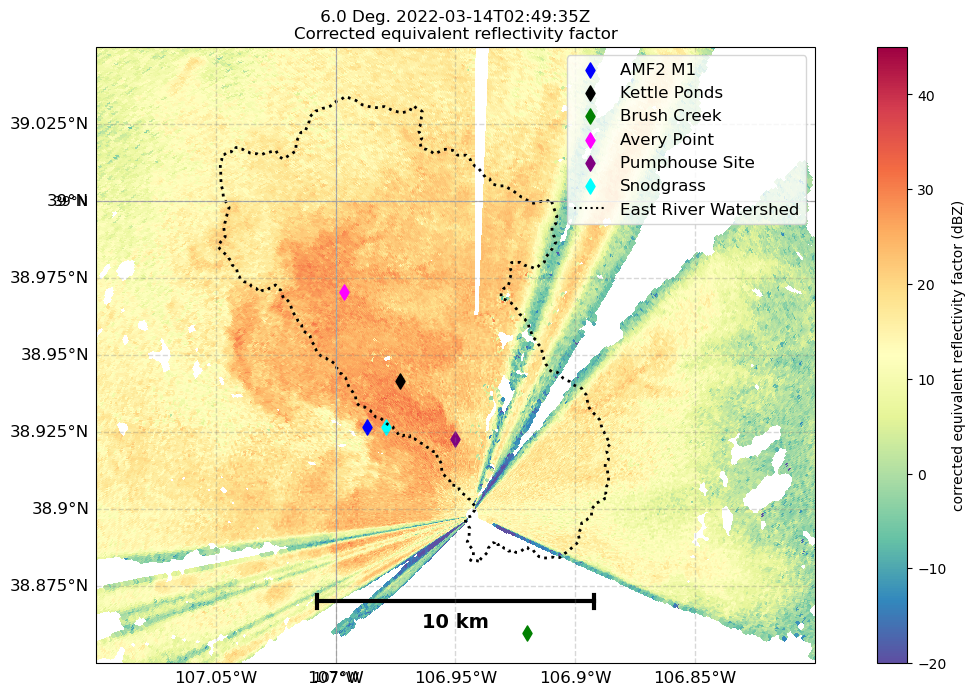

In [26]:
fig = plt.figure(figsize=(16, 8))

axs = plt.subplot(111, projection=ccrs.PlateCarree())

# Create the Radar Display Object
display = pyart.graph.RadarMapDisplay(radar)

# Plot the velocity texture

display.plot_ppi_map('corrected_reflectivity', 
                     ax=axs,
                     sweep=3, 
                     vmin=-20,
                     vmax=45,
                     lat_lines=None,
                     lon_lines=None,
                     min_lat=zoom_min_lat,
                     max_lat=zoom_max_lat,
                     min_lon=zoom_min_lon,
                     max_lon=zoom_max_lon,
                     ticklabs='',
                     embellish=False,
                     norm=None,
                     cmap="Spectral_r")


# Plot the sites!
ncolors = ['blue', 'black', 'green', 'fuchsia', 'purple', 'cyan']
i = 0
for nsite in sites:
    axs.scatter(lons[i], lats[i], c=ncolors[i], s=60, marker='d', label=nsite)
    i += 1

# Plot the East River Watershed domain
plot_eastriver(axs, 'black', zoom=True)

# Save the figure
plt.savefig('OBRIEN_AMS2023_RadCLss_Locations.png')

## B) RadCLss RHI View

### Use pyart.util.columnsect functions (used in RadClSS) to find rays over M1 site. 

In [27]:
col_rays = pyart.util.get_column_rays(radar, 309.5)

In [28]:
col_rays

[977, 2130, 3284, 4441, 5598, 6757, 7914, 8874]

In [29]:
column = pyart.util.get_field_location(radar, lats[0], lons[0])

In [30]:
column.attrs['distance_from_radar']

'4.926 km'

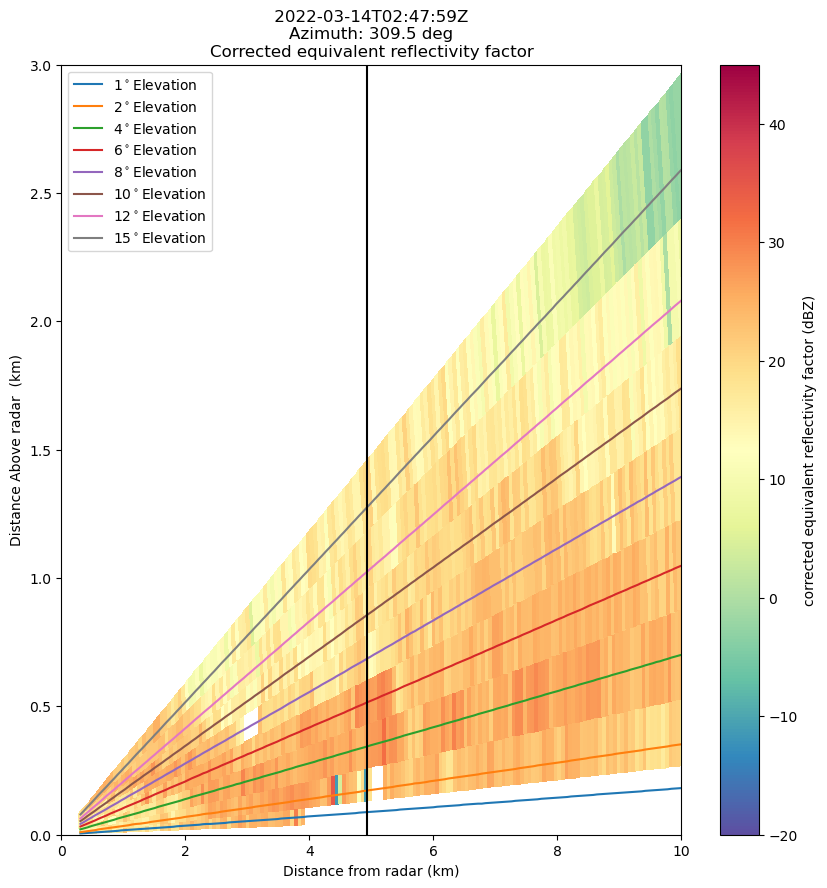

In [31]:
# create new figure
fig2, ax2 = plt.subplots(1, 1, figsize=[10, 10])

# create a pyart display object
display = pyart.graph.RadarDisplay(radar)

display.plot_azimuth_to_rhi('corrected_reflectivity',
                            309.5,
                            ax=ax2,
                            vmin=-20,
                            vmax=45,
                            cmap='Spectral_r')

# convert heights to km and subtract altitude of the radar
heights = (radar.fields['height']['data'] - radar.altitude['data'][0]) / 1000

# Loop over the rays corresponding to the ones of the M1 site
for ray in col_rays:
    nlabel = str(int(np.round(radar.elevation['data'][ray]))) + r"$^\circ$" + "Elevation"
    ax2.plot((radar.range['data'][:] / 1000), heights[ray, :], label=nlabel)
    
# mark where the M1 site is
ax2.axvline(4.926, color='black')

# set limits
ax2.set_xlim([0, 10])
ax2.set_ylim([0, 3])

# create a legend
ax2.legend()

# save figure
plt.savefig("OBRIEN_AMS2023_RadClSS_ColumnExtract.png")

## C) Extra RHI View with terrain plot

In [32]:
# Opening the tif file and getting the values ready to be
# converted into polar values.
rasterfile = tif_file
data_raster = wrl.io.open_raster(rasterfile)
rastervalues, rastercoords, proj = wrl.georef.extract_raster_dataset(
    data_raster, nodata=None)
#rastervalues_, rastercoords_, proj = wrl.georef.extract_raster_dataset(data_raster, nodata=-32768.)
sitecoords = (np.float(radar.longitude['data']),
              np.float(radar.latitude['data']),
              np.float(radar.altitude['data']) + 10.0)

/var/folders/7q/czgy7g_j3fb7jw3256f37wrw0000gq/T/ipykernel_35642/773035183.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sitecoords = (np.float(radar.longitude['data']),
/var/folders/7q/czgy7g_j3fb7jw3256f37wrw0000gq/T/ipykernel_35642/773035183.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(radar.latitude['data']),
/va

In [33]:
beam_width = 1.0
_range = radar.range['data']
#beam_width = np.float(radar.instrument_parameters[
    #'radar_beam_width_v']['data'])
beamradius = wrl.util.half_power_radius(_range, beam_width)
range_res = radar.range['data'][1] - radar.range['data'][0]
nrays = radar.nrays
nbins = radar.ngates
elev = radar.elevation['data']
azimuths = radar.azimuth['data']

rg, azg = np.meshgrid(_range, azimuths)
rg, eleg = np.meshgrid(_range, elev)
coord = wrl.georef.sweep_centroids(nrays, range_res, nbins, eleg)
coords = wrl.georef.spherical_to_proj(rg, azg, eleg,
                                      sitecoords, proj=proj)
lon = coords[..., 0]
lat = coords[..., 1]
alt = coords[..., 2]
polcoords = coords[..., :2]
rlimits = (lon.min(), lat.min(), lon.max(), lat.max())

#Clip the region inside our bounding box
ind = wrl.util.find_bbox_indices(rastercoords, rlimits)
rastercoords = rastercoords[ind[0]:ind[3], ind[0]:ind[2], ...]
rastervalues = rastervalues[ind[0]:ind[3], ind[0]:ind[2]]
polarvalues = wrl.ipol.cart_to_irregular_spline(
    rastercoords, rastervalues, polcoords, order=3,
    prefilter=False)

In [34]:
polarvalues.shape

(9016, 668)

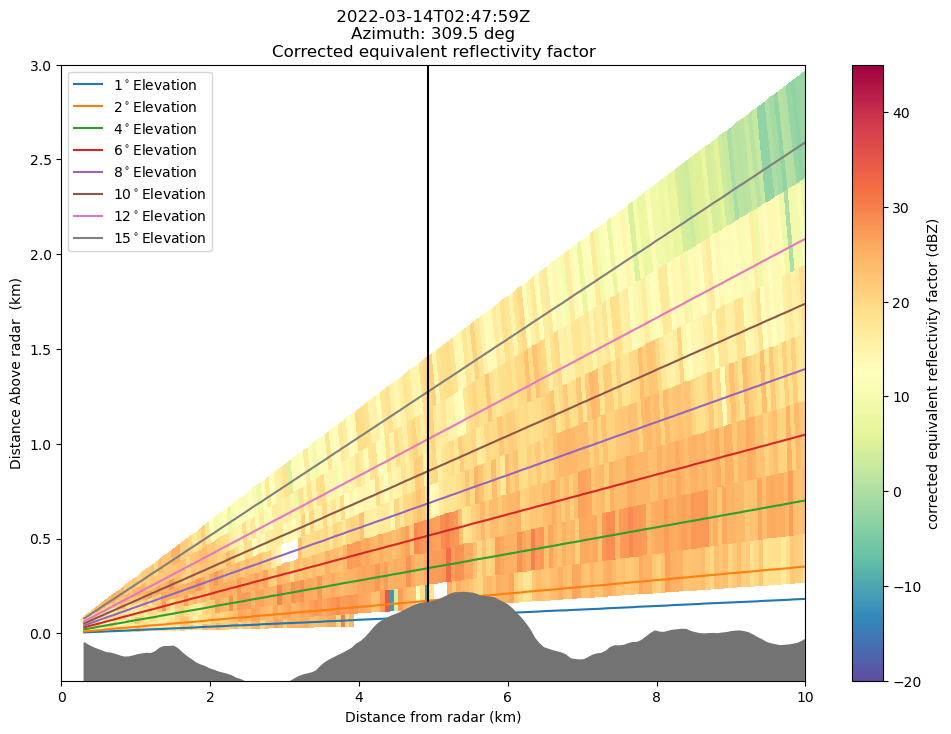

In [35]:
fig3, ax3 = plt.subplots(1, figsize=[12, 8])

npolar = (polarvalues[977, :] - radar.altitude['data'][0]) / 1000

# create a pyart display object
display = pyart.graph.RadarDisplay(radar)

display.plot_azimuth_to_rhi('corrected_reflectivity',
                            309.5,
                            ax=ax3,
                            vmin=-20,
                            vmax=45,
                            cmap='Spectral_r')

# convert heights to km and subtract altitude of the radar
heights = (radar.fields['height']['data'] - radar.altitude['data'][0]) / 1000

# Loop over the rays corresponding to the ones of the M1 site
for ray in col_rays:
    nlabel = str(int(np.round(radar.elevation['data'][ray]))) + r"$^\circ$" + "Elevation"
    ax3.plot((radar.range['data'][:] / 1000), heights[ray, :], label=nlabel)
    
# mark where the M1 site is
ax3.axvline(4.926, color='black')

# set limits
ax3.set_xlim([0, 10])
ax3.set_ylim([-0.1, 3])

# create a legend
ax3.legend()

ax3.fill_between((radar.range['data'] / 1000), 
                 -1, 
                 npolar,
                 color='0.45', 
                 zorder=2.6, 
                 interpolate=True)

plt.ylim(-.25, 3)
plt.xlim(0, 10)

# save figure
plt.savefig("OBRIEN_AMS2023_RadClSS_ColumnExtract_withTerrain.png")

## D) SAIL Mosaic

In [36]:
# Grab all locally stored files
file_list = sorted(glob.glob("/Users/jrobrien/ARM/data/CSU-XPrecipRadar/cmac2/gucxprecipradarcmacM1.c1.20220314*"))
file_list[:10]

['/Users/jrobrien/ARM/data/CSU-XPrecipRadar/cmac2/gucxprecipradarcmacM1.c1.20220314-000239.nc',
 '/Users/jrobrien/ARM/data/CSU-XPrecipRadar/cmac2/gucxprecipradarcmacM1.c1.20220314-001319.nc',
 '/Users/jrobrien/ARM/data/CSU-XPrecipRadar/cmac2/gucxprecipradarcmacM1.c1.20220314-003439.nc',
 '/Users/jrobrien/ARM/data/CSU-XPrecipRadar/cmac2/gucxprecipradarcmacM1.c1.20220314-004519.nc',
 '/Users/jrobrien/ARM/data/CSU-XPrecipRadar/cmac2/gucxprecipradarcmacM1.c1.20220314-005039.nc',
 '/Users/jrobrien/ARM/data/CSU-XPrecipRadar/cmac2/gucxprecipradarcmacM1.c1.20220314-011159.nc',
 '/Users/jrobrien/ARM/data/CSU-XPrecipRadar/cmac2/gucxprecipradarcmacM1.c1.20220314-013839.nc',
 '/Users/jrobrien/ARM/data/CSU-XPrecipRadar/cmac2/gucxprecipradarcmacM1.c1.20220314-015439.nc',
 '/Users/jrobrien/ARM/data/CSU-XPrecipRadar/cmac2/gucxprecipradarcmacM1.c1.20220314-021039.nc',
 '/Users/jrobrien/ARM/data/CSU-XPrecipRadar/cmac2/gucxprecipradarcmacM1.c1.20220314-021559.nc']

In [38]:
# Plot the radar loop
#%%time
for file in file_list[1:]:
    if file[-3:] != "MDM":
        figB = sail_mosaic(file, rad_ds, accum)
        nout = 'OBRIEN_SAIL_Mosaic_' + file.split('/')[-1] +'.png'
        print(nout)
        figB.savefig(nout)
        plt.close(figB)

2022-03-14 00:13:19


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 00:13:19
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-001319.nc.png
2022-03-14 00:34:39


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 00:34:39
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-003439.nc.png
2022-03-14 00:45:19


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 00:45:19
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-004519.nc.png
2022-03-14 00:50:39


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 00:50:39
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-005039.nc.png
2022-03-14 01:11:59


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 01:11:59
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-011159.nc.png
2022-03-14 01:38:39


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 01:38:39
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-013839.nc.png
2022-03-14 01:54:39


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 01:54:39
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-015439.nc.png
2022-03-14 02:10:39


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 02:10:39
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-021039.nc.png
2022-03-14 02:15:59


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 02:15:59
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-021559.nc.png
2022-03-14 02:31:59


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 02:31:59
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-023159.nc.png
2022-03-14 02:37:19


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 02:37:19
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-023719.nc.png
2022-03-14 02:42:39


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 02:42:39
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-024239.nc.png
2022-03-14 02:47:59


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 02:47:59
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-024759.nc.png
2022-03-14 03:09:20


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 03:09:20
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-030920.nc.png
2022-03-14 03:25:20


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 03:25:20
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-032520.nc.png
2022-03-14 03:30:40


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 03:30:40
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-033040.nc.png
2022-03-14 03:36:00


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 03:36:00
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-033600.nc.png
2022-03-14 03:41:20


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 03:41:20
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-034120.nc.png
2022-03-14 03:46:40


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 03:46:40
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-034640.nc.png
2022-03-14 03:57:20


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 03:57:20
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-035720.nc.png
2022-03-14 04:02:40


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 04:02:40
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-040240.nc.png
2022-03-14 04:13:20


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 04:13:20
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-041320.nc.png
2022-03-14 04:18:40


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 04:18:40
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-041840.nc.png
2022-03-14 04:24:00


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 04:24:00
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-042400.nc.png
2022-03-14 04:29:20


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 04:29:20
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-042920.nc.png
2022-03-14 05:01:20


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 05:01:20
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-050120.nc.png
2022-03-14 05:33:20


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 05:33:20
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-053320.nc.png
2022-03-14 05:38:40


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 05:38:40
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-053840.nc.png
2022-03-14 05:44:01


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 05:44:01
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-054401.nc.png
2022-03-14 05:54:40


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 05:54:40
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-055440.nc.png
2022-03-14 06:16:01


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 06:16:01
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-061601.nc.png
2022-03-14 06:21:21


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 06:21:21
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-062121.nc.png
2022-03-14 06:48:01


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 06:48:01
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-064801.nc.png
2022-03-14 06:53:21


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 06:53:21
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-065321.nc.png
2022-03-14 07:04:01


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 07:04:01
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-070401.nc.png
2022-03-14 07:14:41


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 07:14:41
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-071441.nc.png
2022-03-14 07:25:21


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 07:25:21
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-072521.nc.png
2022-03-14 07:30:41


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 07:30:41
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-073041.nc.png
2022-03-14 07:36:01


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 07:36:01
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-073601.nc.png
2022-03-14 07:57:21


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 07:57:21
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-075721.nc.png
2022-03-14 08:13:21


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 08:13:21
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-081321.nc.png
2022-03-14 08:18:41


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 08:18:41
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-081841.nc.png
2022-03-14 08:24:01


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 08:24:01
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-082401.nc.png
2022-03-14 08:29:21


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 08:29:21
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-082921.nc.png
2022-03-14 08:40:01


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 08:40:01
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-084001.nc.png
2022-03-14 08:45:21


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 08:45:21
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-084521.nc.png
2022-03-14 09:06:42


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 09:06:42
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-090642.nc.png
2022-03-14 09:38:42


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 09:38:42
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-093842.nc.png
2022-03-14 09:49:22


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 09:49:22
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-094922.nc.png
2022-03-14 09:54:42


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 09:54:42
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-095442.nc.png
2022-03-14 10:16:02


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 10:16:02
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-101602.nc.png
2022-03-14 10:21:22


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 10:21:22
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-102122.nc.png
2022-03-14 10:37:22


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 10:37:22
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-103722.nc.png
2022-03-14 11:20:02


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 11:20:02
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-112002.nc.png
2022-03-14 11:25:22


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 11:25:22
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-112522.nc.png
2022-03-14 11:36:02


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 11:36:02
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-113602.nc.png
2022-03-14 11:57:23


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 11:57:23
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-115723.nc.png
2022-03-14 12:02:43


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 12:02:43
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-120243.nc.png
2022-03-14 12:08:03


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 12:08:03
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-120803.nc.png
2022-03-14 12:34:43


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 12:34:43
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-123443.nc.png
2022-03-14 12:40:03


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 12:40:03
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-124003.nc.png
2022-03-14 12:50:43


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 12:50:43
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-125043.nc.png
2022-03-14 12:56:03


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 12:56:03
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-125603.nc.png
2022-03-14 13:01:23


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 13:01:23
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-130123.nc.png
2022-03-14 13:12:03


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 13:12:03
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-131203.nc.png
2022-03-14 13:17:23


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 13:17:23
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-131723.nc.png
2022-03-14 13:22:43


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 13:22:43
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-132243.nc.png
2022-03-14 13:49:23


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 13:49:23
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-134923.nc.png
2022-03-14 14:00:03


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 14:00:03
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-140003.nc.png
2022-03-14 14:21:23


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 14:21:23
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-142123.nc.png
2022-03-14 15:30:44


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 15:30:44
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-153044.nc.png
2022-03-14 15:36:04


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 15:36:04
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-153604.nc.png
2022-03-14 15:46:44


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 15:46:44
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-154644.nc.png
2022-03-14 15:57:24


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 15:57:24
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-155724.nc.png
2022-03-14 16:18:44


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 16:18:44
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-161844.nc.png
2022-03-14 16:34:44


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 16:34:44
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-163444.nc.png
2022-03-14 16:45:24


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 16:45:24
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-164524.nc.png
2022-03-14 16:50:44


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 16:50:44
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-165044.nc.png
2022-03-14 17:01:24


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 17:01:24
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-170124.nc.png
2022-03-14 17:12:04


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 17:12:04
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-171204.nc.png
2022-03-14 17:22:44


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 17:22:44
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-172244.nc.png
2022-03-14 17:33:24


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 17:33:24
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-173324.nc.png
2022-03-14 17:38:44


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 17:38:44
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-173844.nc.png
2022-03-14 17:49:24


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 17:49:24
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-174924.nc.png
2022-03-14 17:54:45


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 17:54:45
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-175445.nc.png
2022-03-14 18:10:44


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 18:10:44
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-181044.nc.png
2022-03-14 18:21:25


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 18:21:25
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-182125.nc.png
2022-03-14 18:26:45


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 18:26:45
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-182645.nc.png
2022-03-14 18:42:45


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 18:42:45
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-184245.nc.png
2022-03-14 18:53:25


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 18:53:25
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-185325.nc.png
2022-03-14 18:58:45


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 18:58:45
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-185845.nc.png
2022-03-14 19:04:05


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 19:04:05
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-190405.nc.png
2022-03-14 19:09:25


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 19:09:25
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-190925.nc.png
2022-03-14 19:20:05


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 19:20:05
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-192005.nc.png
2022-03-14 19:25:25


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 19:25:25
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-192525.nc.png
2022-03-14 19:30:45


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 19:30:45
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-193045.nc.png
2022-03-14 19:52:05


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 19:52:05
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-195205.nc.png
2022-03-14 19:57:25


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 19:57:25
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-195725.nc.png
2022-03-14 20:08:05


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 20:08:05
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-200805.nc.png
2022-03-14 20:13:25


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 20:13:25
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-201325.nc.png
2022-03-14 20:34:45


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 20:34:45
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-203445.nc.png
2022-03-14 20:40:05


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 20:40:05
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-204005.nc.png
2022-03-14 20:56:06


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 20:56:06
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-205606.nc.png
2022-03-14 21:06:46


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 21:06:46
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-210646.nc.png
2022-03-14 21:17:26


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 21:17:26
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-211726.nc.png
2022-03-14 22:00:06


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 22:00:06
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-220006.nc.png
2022-03-14 22:05:26


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 22:05:26
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-220526.nc.png
2022-03-14 22:21:26


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 22:21:26
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-222126.nc.png
2022-03-14 22:32:06


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 22:32:06
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-223206.nc.png
2022-03-14 22:37:26


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 22:37:26
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-223726.nc.png
2022-03-14 22:48:06


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 22:48:06
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-224806.nc.png
2022-03-14 22:58:46


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 22:58:46
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-225846.nc.png
2022-03-14 23:09:26


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 23:09:26
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-230926.nc.png
2022-03-14 23:20:06


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 23:20:06
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-232006.nc.png
2022-03-14 23:25:26


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 23:25:26
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-232526.nc.png
2022-03-14 23:36:07


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 23:36:07
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-233607.nc.png
2022-03-14 23:57:27


/opt/homebrew/Caskroom/miniforge/base/envs/sail-xprecip-dev/lib/python3.9/site-packages/cartopy/crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


2022-03-14T00:06:47.000000000
2022-03-14 23:57:27
OBRIEN_SAIL_Mosaic_gucxprecipradarcmacM1.c1.20220314-235727.nc.png
